<a href="https://colab.research.google.com/github/harryypham/MyMLPractice/blob/main/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

%matplotlib inline

In [86]:
batch_size = 64

train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.28604, 0.35302)
])
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(0.28604, 0.35302)
])

trainset = torchvision.datasets.FashionMNIST("/content/data", train=True, download=True, transform=train_transform)
testset = torchvision.datasets.FashionMNIST("/content/data", train=False, download=True, transform=test_transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=2)

In [87]:
class Encoder(nn.Module):
  def __init__(self, dims):
    super(Encoder, self).__init__()
    self.conv_net = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
    )
    self.mean = nn.Linear(2048, dims)
    self.log_var = nn.Linear(2048, dims)
    self.N = torch.distributions.Normal(0, 1)
    self.loss = 0

  def forward(self, x):
    out = self.conv_net(x)
    out = out.view(out.size(0), -1)

    z_mean = self.mean(out)
    z_log_var = self.log_var(out)
    z_sigma = torch.exp(z_log_var * 0.5)

    #Sampling
    epsilon = self.N.sample(z_mean.shape).to(device)
    z = z_mean + z_sigma*epsilon

    #KL Loss
    loss =  -0.5 * (1 + z_log_var - z_mean**2 - torch.exp(z_log_var)).sum()
    return z


class Decoder(nn.Module):
  def __init__(self, dims):
    super(Decoder, self).__init__()
    self.fc = nn.Linear(dims, 2048)
    self.net = nn.Sequential(
        nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),

    )
    self.conv1 = nn.Sequential(
        nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    out = self.fc(x)
    out = out.reshape((out.size(0), 128, 4, 4))
    out = self.net(out)
    out = self.conv1(out)
    return out

class VAE(nn.Module):
  def __init__(self, dims):
    super(VAE, self).__init__()
    self.encoder = Encoder(dims)
    self.decoder = Decoder(dims)

  def forward(self, x):
    z = self.encoder(x)
    out = self.decoder(z)
    return out



In [88]:
def train(model, dataloader, opt, criterion, num_epochs=5, device="cpu"):
  for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}:')
    train_loss = 0
    for batch_idx, (inputs, targets) in enumerate(dataloader):
      inputs = inputs.to(device)
      opt.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, inputs) + model.encoder.loss
      loss.backward()
      opt.step()

      with torch.no_grad():
        train_loss += loss.item()
        if (not batch_idx % 100) and batch_idx != 0:
                print ('Batch %03d | Cost: %.6f'
                      %(batch_idx, train_loss/(batch_idx+1)))
  return model

In [5]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

model = Encoder(2)
model.to(device)
x = torch.rand((1, 1, 32, 32)).to(device)
out = model(x)
print(out.shape)

torch.Size([1, 2])


In [98]:
model = VAE(2)
model.to(device)
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()

trained_model = train(model, trainloader, optimizer, criterion, device=device)




Epoch 1:
Batch 100 | Cost: 0.761091
Batch 200 | Cost: 0.668230
Batch 300 | Cost: 0.627577
Batch 400 | Cost: 0.604419
Batch 500 | Cost: 0.589038
Batch 600 | Cost: 0.577710
Batch 700 | Cost: 0.569231
Batch 800 | Cost: 0.562639
Batch 900 | Cost: 0.557246

Epoch 2:
Batch 100 | Cost: 0.511963
Batch 200 | Cost: 0.510876
Batch 300 | Cost: 0.509946
Batch 400 | Cost: 0.508962
Batch 500 | Cost: 0.508743
Batch 600 | Cost: 0.508322
Batch 700 | Cost: 0.507343
Batch 800 | Cost: 0.506416
Batch 900 | Cost: 0.506347

Epoch 3:
Batch 100 | Cost: 0.500805
Batch 200 | Cost: 0.500758
Batch 300 | Cost: 0.502031
Batch 400 | Cost: 0.502232
Batch 500 | Cost: 0.502134
Batch 600 | Cost: 0.501774
Batch 700 | Cost: 0.501377
Batch 800 | Cost: 0.501389
Batch 900 | Cost: 0.501019

Epoch 4:
Batch 100 | Cost: 0.500024
Batch 200 | Cost: 0.498017
Batch 300 | Cost: 0.497204
Batch 400 | Cost: 0.497993
Batch 500 | Cost: 0.497309
Batch 600 | Cost: 0.497240
Batch 700 | Cost: 0.497180
Batch 800 | Cost: 0.497514
Batch 900 | Cos

In [37]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

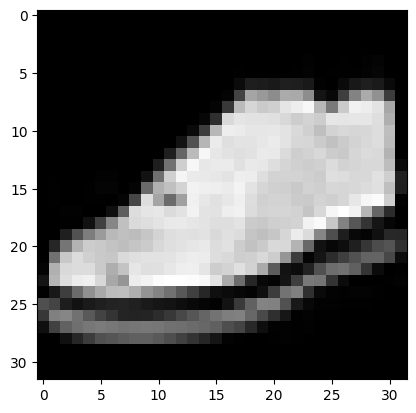

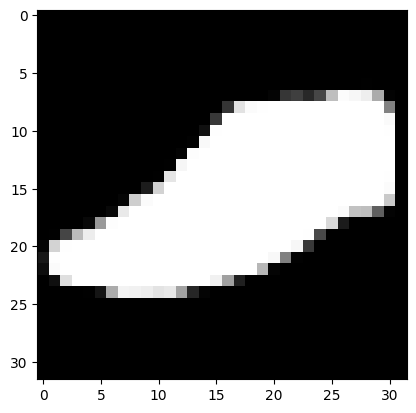

In [96]:

i = 1
unnormalizer = UnNormalize([0.28604], [0.35302])
x, _ = next(iter(trainloader))
outputs = model(x.to(device))
x_unnorm = unnormalizer(x[i])
outputs = unnormalizer(outputs[i].cpu().detach())

plt.imshow(x_unnorm.numpy()[0], cmap='gray')
plt.show()
plt.imshow(outputs.numpy()[0], cmap='gray')


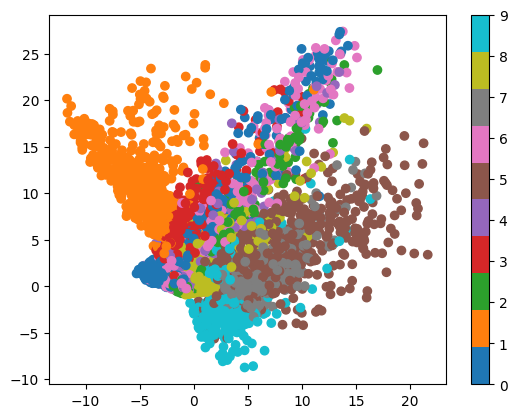

In [99]:
def plot_latent(model, dataloader, num_batches=100):
    for i, (x, y) in enumerate(dataloader):
        z = model.encoder(x.to(device))
        z = z.to('cpu').detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            plt.colorbar()
            break

plot_latent(model, trainloader)